In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path as P
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
from collections import defaultdict
import plotly.express as px
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [92]:
learning_rate=0.001
train_size=0.8
seqlen=6
bs=32
epochs=200

这些是模型的超参数。
- learning_rate 是学习率，控制模型收敛的快慢，太大了模型容易发散，太小了模型收敛很慢；
- train_size 训练集占整个数据集的比例，一般是28开；
- seqlen：序列长度，在时序建模中，就是用前几个样本来预测当前样本；
- bs：batch size，批量大小，随机梯度下降算法SGD中，每次用来估计梯度的训练样本数量；
考虑到数据集本身只有100多个样本，批量不用太大；
- epochs：训练的轮数，即迭代次数；

In [93]:
df=pd.read_csv('问题2-训练数据-归一化.csv',index_col='time')

In [94]:
df_train, df_val = train_test_split(df, train_size=train_size, shuffle=False)

将数据集分割为训练集和验证集，二者没有交集，训练集用来训练模型，验证集用来确保模型没有过拟合。

In [95]:
feature_size=df_train.shape[1]
df_train.shape, df_val.shape

((98, 7), (25, 7))

In [96]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    df_train.values, df_train.values, sequence_length=seqlen, batch_size=bs, shuffle=True)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    df_val.values, df_val.values, sequence_length=seqlen, batch_size=bs, shuffle=True)

利用keras的接口构造时序模型需要的时序数据集。

In [97]:
dataset_train, dataset_val

(<BatchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>)

构建一个单层的LSTM模型。LSTM是一种专门用来建模时序数据的神经网络模型，即长短期记忆（Long Short Term Memory）。
可以展开说说理论。

In [98]:
inputs = keras.layers.Input(shape=(seqlen, feature_size))
lstm_out = keras.layers.LSTM(5)(inputs)
outputs = keras.layers.Dense(feature_size)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 6, 7)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 5)                 260       
                                                                 
 dense_12 (Dense)            (None, 7)                 42        
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


训练模型：
1. 使用的损失函数：MSE，Mean Square Error，即均方误差；
2. 早停止：当验证误差经过一段时间不再改进之后，停止训练模型，这是一种停止训练循环的策略；
3. 检查点：当验证误差出现改进时，保存当前的模型参数；

In [99]:
path_checkpoint = "problem2_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    # 要同时保存网络结构。
    save_weights_only=False,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/200
1/3 [=========>....................] - ETA: 3s - loss: 0.4122
Epoch 1: val_loss improved from inf to 0.37868, saving model to problem2_checkpoint.h5
3/3 [==============================] - 2s 218ms/step - loss: 0.3809 - val_loss: 0.3787
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3278
Epoch 2: val_loss improved from 0.37868 to 0.36398, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.3631 - val_loss: 0.3640
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3801
Epoch 3: val_loss improved from 0.36398 to 0.35080, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 65ms/step - loss: 0.3471 - val_loss: 0.3508
Epoch 4/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3210
Epoch 4: val_loss improved from 0.35080 to 0.33918, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.3317 - val_loss: 0.3392

3/3 [==============================] - 0s 47ms/step - loss: 0.1332 - val_loss: 0.2327
Epoch 34/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1313
Epoch 34: val_loss improved from 0.23270 to 0.22921, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.1295 - val_loss: 0.2292
Epoch 35/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1262
Epoch 35: val_loss improved from 0.22921 to 0.22538, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.1257 - val_loss: 0.2254
Epoch 36/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1098
Epoch 36: val_loss improved from 0.22538 to 0.22138, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.1218 - val_loss: 0.2214
Epoch 37/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1100
Epoch 37: val_loss improved from 0.22138 to 0.21734, saving model to problem2_ch

1/3 [=========>....................] - ETA: 0s - loss: 0.0391
Epoch 66: val_loss improved from 0.12970 to 0.12907, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0406 - val_loss: 0.1291
Epoch 67/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0444
Epoch 67: val_loss improved from 0.12907 to 0.12863, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0399 - val_loss: 0.1286
Epoch 68/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0397
Epoch 68: val_loss improved from 0.12863 to 0.12825, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0392 - val_loss: 0.1283
Epoch 69/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0360
Epoch 69: val_loss improved from 0.12825 to 0.12796, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0386 - val_loss: 0.1280
E

3/3 [==============================] - 0s 52ms/step - loss: 0.0325 - val_loss: 0.1241
Epoch 100/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0359
Epoch 100: val_loss improved from 0.12410 to 0.12403, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0324 - val_loss: 0.1240
Epoch 101/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0321
Epoch 101: val_loss improved from 0.12403 to 0.12387, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0322 - val_loss: 0.1239
Epoch 102/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0291
Epoch 102: val_loss improved from 0.12387 to 0.12374, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0321 - val_loss: 0.1237
Epoch 103/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0332
Epoch 103: val_loss improved from 0.12374 to 0.12345, saving model to pro

Epoch 134/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0248
Epoch 134: val_loss improved from 0.12133 to 0.12121, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0272 - val_loss: 0.1212
Epoch 135/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0290
Epoch 135: val_loss improved from 0.12121 to 0.12105, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0270 - val_loss: 0.1210
Epoch 136/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0198
Epoch 136: val_loss did not improve from 0.12105
3/3 [==============================] - 0s 35ms/step - loss: 0.0269 - val_loss: 0.1211
Epoch 137/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0283
Epoch 137: val_loss improved from 0.12105 to 0.12080, saving model to problem2_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0267 - val_loss: 0.1208
Epoch 138/200
1/3 [=====

对模型训练过程的损失函数和验证损失函数进行可视化。
- 基于matplotlib的可视化；
- 基于plotly的可视化；

挑一个好看的就行。

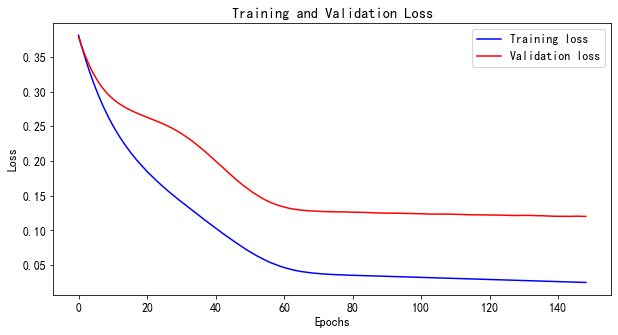

In [100]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")